In [1]:
import os
import numpy as np
import random
import pandas as pd
pd.options.display.max_rows = 999

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

import tensorflow as tf

from SOAI.handler.SOAIDiskHandler import SOAIDiskHandler

INFO - __init__ : <module>() - Use /home/nils/workspace/school_of_ai/projects/air-quality-backend/SOAI/.. as project path.
WARNING - __init__ : <module>() - SOAI_MODEL_PATH not set
INFO - __init__ : <module>() - SOAI env var is set to /home/nils/workspace/school_of_ai/projects/air-quality-backend/SOAI/..


## Helper functions

In [2]:
def printLists(sensorIDs, dataNO2List, dataTrafficList):
    for sensor, dataNO2, dataTraffic in zip(sensorIDs, dataNO2List, dataTrafficList):
        print(f"====== Sensor {sensor} =======")
        print("*** Sensor data ***")
        print(f"Lenght of sensor data {len(dataNO2)}")
        print(dataNO2.head())
        print("\n")
        print("*** Traffic data ***")
        print(f"Lenght of traffic data {len(dataTraffic)}")
        print(dataTraffic.head())
        print("\n")

## Load data

In [3]:
dataHandler = SOAIDiskHandler()

dfOpenAir = dataHandler.fGetOpenAir(os.environ.get("SOAI") + "/data/openair/", selectValidData=True)
dfOpenAirLocation = dataHandler.fGetOpenAirSensors()

dfLanuv = dataHandler.fGetLanuv(os.environ.get("SOAI") + "/data/lanuv/", selectValidData=True)
dfLanuv.index = dfLanuv.index.tz_localize(None)  # Needed to joind with traffic data later on
dfLanuv.index =  pd.to_datetime(dfLanuv.index, format='%Y-%m-%d %H:%M:%S')
dfLanuvLocation = dataHandler.fGetLanuvSensors()

dfTraffic = dataHandler.fGetTrafficData(os.environ.get("SOAI") + "/data/traffic/")

DEBUG - SOAIDiskHandler : fGetOpenAir() - Load OpenAir Cologne data from /home/nils/workspace/school_of_ai/projects/air-quality-backend/SOAI/../data/openair/.
DEBUG - SOAIDiskHandler : fGetOpenAir() - 	- Load /home/nils/workspace/school_of_ai/projects/air-quality-backend/SOAI/../data/openair/df_openair6.parquet
DEBUG - SOAIDiskHandler : fGetOpenAir() - 	- Load /home/nils/workspace/school_of_ai/projects/air-quality-backend/SOAI/../data/openair/df_openair2.parquet
DEBUG - SOAIDiskHandler : fGetOpenAir() - 	- Load /home/nils/workspace/school_of_ai/projects/air-quality-backend/SOAI/../data/openair/df_openair4.parquet
DEBUG - SOAIDiskHandler : fGetOpenAir() - 	- Load /home/nils/workspace/school_of_ai/projects/air-quality-backend/SOAI/../data/openair/df_openair3.parquet
DEBUG - SOAIDiskHandler : fGetOpenAir() - 	- Load /home/nils/workspace/school_of_ai/projects/air-quality-backend/SOAI/../data/openair/df_openair5.parquet
DEBUG - SOAIDiskHandler : fGetOpenAir() - 	- Load /home/nils/workspace/

In [4]:
dfTraffic.head()

,green,orange,red,brown,pixelCounterSensor,rgreen,rorange,rred,rbrown,sensorID,pixel
date,,,,,,,,,,,
2019-08-01,2313.0,0.0,0.0,0.0,2313.0,1.0,0.0,0.0,0.0,VKCL,20
2019-08-01,647.0,0.0,0.0,0.0,647.0,1.0,0.0,0.0,0.0,VKCL,5
2019-08-01,943.0,0.0,0.0,0.0,943.0,1.0,0.0,0.0,0.0,VKTU,10
2019-08-01,382.0,0.0,0.0,0.0,382.0,1.0,0.0,0.0,0.0,VKCL,3
2019-08-01,1811.0,0.0,0.0,0.0,1811.0,1.0,0.0,0.0,0.0,VKTU,20


## Filter and prepare data

In [11]:
# Choose the sensors and the pixel size around each sensor

#sensorIDs = ["VKCL", "CHOR", "VKTU", "RODE"]
#sensorIDs = ["VKCL", "VKTU"]
sensorIDs = ["VKCL"]

pixelAroundSensor = 5

In [12]:
# Use list to process data, since multiple sensor can be used for training
# Each element in the list corresponds to one dataframe for one sensor
dataNO2List = []
dataTrafficList = []

for sensor in sensorIDs:
    dataNO2 = dfLanuv[dfLanuv["sensorID"] == sensor]
    dataNO2List.append(dataNO2)
    
    dataTraffic = dfTraffic[dfTraffic["sensorID"] == sensor]
    dataTraffic = dataTraffic[dataTraffic["pixel"] == pixelAroundSensor]
    dataTrafficList.append(dataTraffic)
    
printLists(sensorIDs, dataNO2List, dataTrafficList)

====== Sensor VKCL =======
*** Sensor data ***
Lenght of sensor data 11713
                    sensorID    NO  OZON   no2  wr  wg  temp  wtime  hum
timestamp                                                               
2018-08-14 08:00:00     VKCL  92.0   NaN  53.0 NaN NaN   NaN    NaN  NaN
2018-08-14 10:00:00     VKCL  78.0   NaN  55.0 NaN NaN   NaN    NaN  NaN
2018-08-14 11:00:00     VKCL  68.0   NaN  55.0 NaN NaN   NaN    NaN  NaN
2018-08-14 12:00:00     VKCL  70.0   NaN  55.0 NaN NaN   NaN    NaN  NaN
2018-08-14 13:00:00     VKCL  82.0   NaN  75.0 NaN NaN   NaN    NaN  NaN


*** Traffic data ***
Lenght of traffic data 20140
                     green  orange  red  brown  pixelCounterSensor  rgreen  \
date                                                                         
2019-08-01 00:00:00  647.0     0.0  0.0    0.0               647.0     1.0   
2019-08-01 00:15:00  614.0     0.0  0.0    0.0               614.0     1.0   
2019-08-01 00:30:00  644.0     0.0  0.0    0.0    

Resample data and keep overlapp between no2 dataframe and traffic dataframe

In [13]:
for i in range(len(sensorIDs)):
    dataNO2List[i] = dataNO2List[i].resample("1h").mean()
    dataTrafficList[i] = dataTrafficList[i].resample("1h").mean()
    
    timeMin = max(dataNO2List[i].index.min(), dataTrafficList[i].index.min())
    timeMax = min(dataNO2List[i].index.max(), dataTrafficList[i].index.max())

    dataNO2List[i] = dataNO2List[i].loc[(dataNO2List[i].index >= timeMin) & (dataNO2List[i].index <=   timeMax)]
    dataTrafficList[i] = dataTrafficList[i].loc[(dataTrafficList[i].index >= timeMin) & (dataTrafficList[i].index <= timeMax)]

Enrich features and interpolate

In [14]:
for i in range(len(sensorIDs)):
    dataNO2List[i]["wr_cos"] = dataNO2List[i]["wr"].apply(lambda x: np.cos(x))
    dataNO2List[i]["wr_sin"] = dataNO2List[i]["wr"].apply(lambda x: np.sin(x))

    dataNO2List[i]["no2_ip"] = dataNO2List[i].interpolate()["no2"]
    dataNO2List[i]["wg_ip"] = dataNO2List[i].interpolate()["wg"]
    dataNO2List[i]["hum_ip"] = dataNO2List[i].interpolate()["hum"]
    dataNO2List[i]["temp_ip"] = dataNO2List[i].interpolate()["temp"]
    dataNO2List[i]["wr_cos_ip"] = dataNO2List[i].interpolate()["wr_cos"]
    dataNO2List[i]["wr_sin_ip"] = dataNO2List[i].interpolate()["wr_sin"]
    
    # Append classification information
    featureUpAndDown = []
    no2Values = dataNO2List[i]["no2_ip"]
    for j in range(0, len(no2Values)-1):
        upAndDown = 0
        if no2Values[j+1] > no2Values[j]:
            upAndDown = 1
        else:
            upAndDown = 0
        featureUpAndDown.append(upAndDown)
    featureUpAndDown.append(0)
    dataNO2List[i]["no2_ip_trend"] = featureUpAndDown

In [15]:
dataTrainList = []
for i in range(len(sensorIDs)):
    dataTrain = pd.concat([dataNO2List[i], dataTrafficList[i]], sort=False, axis=1)
    dataTrainList.append(dataTrain)

dataTrain = pd.concat(dataTrainList)

In [27]:
dataTrain[["no2", "no2_ip_trend"]]

,no2,no2_ip_trend
timestamp,,
2019-08-26 00:00:00,87.0,0
2019-08-26 01:00:00,79.0,0
2019-08-26 02:00:00,75.0,0
2019-08-26 03:00:00,61.0,0
2019-08-26 04:00:00,57.0,1
...,...,...
2020-02-26 14:00:00,45.0,1
2020-02-26 15:00:00,59.0,1
2020-02-26 16:00:00,61.0,0


## Train the model

Set input and output features

In [16]:
#featureNames = ["rgreen", "rorange", "rred", "rbrown", "hum_ip", "temp_ip", "wg_ip", "wr_cos_ip", "wr_sin_ip"]
featureNames = ["no2_ip", "rgreen", "rorange", "rred", "rbrown", "hum_ip", "temp_ip", "wg_ip"]
#featureNames = ["rgreen", "rorange", "rred", "rbrown"]
targetName = ["no2_ip_trend"]
nFeatures = len(featureNames)

dataTrain = dataTrain.dropna(subset=featureNames + targetName)

features = dataTrain[featureNames].values
target = dataTrain[targetName].values
indexTime = dataTrain.index

Scale input features

In [17]:
scaler = StandardScaler()
featuresScaled = scaler.fit_transform(features)

Create train / test split

In [18]:
featuresTrain, featuresTest, targetTrain, targetTest = train_test_split(featuresScaled, target, test_size=0.1, shuffle=False)
indexTrain, indexTest = train_test_split(indexTime, test_size=0.1, shuffle=False)

### Classifier (up and down)

Create model

In [25]:
seed_value= 40

tf.keras.backend.clear_session()
tf.random.set_seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

epochs=50
batch=20
lr = 0.005

input1 = tf.keras.Input((nFeatures,))
dense1 = tf.keras.layers.Dense(20, activation="relu")(input1)
dense2 = tf.keras.layers.Dense(10, activation="relu")(dense1)
dense3 = tf.keras.layers.Dense(5, activation="relu")(dense2)
output = tf.keras.layers.Dense(1, activation="sigmoid")(dense3) # activation="linear"

model = tf.keras.Model(inputs=[input1], outputs=[output])
model.compile(optimizer=tf.keras.optimizers.Adam(lr, decay=lr/epochs), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense (Dense)                (None, 20)                180       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 451
Trainable params: 451
Non-trainable params: 0
_________________________________________________________________


Train

Train on 3591 samples, validate on 400 samples
Epoch 1/50
3591/3591 [==============================] - 2s 443us/sample - loss: 0.6694 - accuracy: 0.5893 - val_loss: 0.6447 - val_accuracy: 0.6300
Epoch 2/50
3591/3591 [==============================] - 1s 225us/sample - loss: 0.6575 - accuracy: 0.6004 - val_loss: 0.6446 - val_accuracy: 0.6400
Epoch 3/50
3591/3591 [==============================] - 1s 207us/sample - loss: 0.6552 - accuracy: 0.6157 - val_loss: 0.6506 - val_accuracy: 0.6150
Epoch 4/50
3591/3591 [==============================] - 1s 201us/sample - loss: 0.6518 - accuracy: 0.6107 - val_loss: 0.6556 - val_accuracy: 0.6075
Epoch 5/50
3591/3591 [==============================] - 1s 200us/sample - loss: 0.6519 - accuracy: 0.6188 - val_loss: 0.6533 - val_accuracy: 0.6100
Epoch 6/50
3591/3591 [==============================] - 1s 205us/sample - loss: 0.6504 - accuracy: 0.6202 - val_loss: 0.6419 - val_accuracy: 0.6400
Epoch 7/50
3591/3591 [==============================] - 1s 204us/

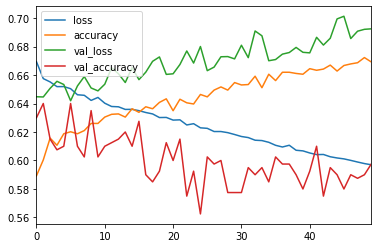

In [24]:
#checkpoint_sb = keras.callbacks.ModelCheckpoint("SOAI.h5", save_best_only=True)

history = model.fit(featuresTrain, targetTrain, epochs=epochs, validation_split=0.1, batch_size=batch)

#model = keras.models.load_model("SOAI.h5")

model.evaluate(featuresTest, targetTest)
prediction = model.predict(featuresTest)
predictionTrain = model.predict(featuresTrain)

pd.DataFrame(history.history).plot()

Plot

Training set

In [28]:
predictionTrain_plot = pd.Series(predictionTrain.T[0], index=indexTrain)
targetTrain_plot = pd.Series(targetTrain, index=indexTrain)

fig, ax = subplots()
targetTrain_plot.plot(figsize=(20,10), fontsize=20, ax=ax)
predictionTrain_plot.plot(figsize=(20,10), fontsize=20, ax=ax)
ax.set_title(sensorID, fontsize=25)

Exception: Data must be 1-dimensional

Test set

In [ ]:
predictionTest_plot = pd.Series(prediction.T[0], index=indexTest)
targetTest_plot = pd.Series(targetTest, index=indexTest)

fig, ax = subplots()
targetTest_plot.plot(figsize=(20,10), fontsize=20, ax=ax)
predictionTest_plot.plot(figsize=(20,10), fontsize=20, ax=ax)
ax.set_title(sensorID, fontsize=25)

### Classifier (over threshold)

In [ ]:
dataTrain["no2_ip_trend"] = dataTrain["no2_ip"].apply(lambda x: 1 if x > 40 else 0)